# Data Literacy
#### University of Tübingen, Winter Term 2021/22
## Exercise Sheet 9
&copy; 2021 Prof. Dr. Philipp Hennig & Lukas Tatzel

This sheet is **due on Monday 10 January 2022 at 10 am sharp (i.e. before the start of the lecture).**

---

## Fair PCA

**What is this week's tutorial about?** 
As you have seen in the lecture, the application of the "classical" PCA can lead to unbalanced reconstruction errors for different groups of the dataset. For example, applying PCA to the [LFW dataset](http://vis-www.cs.umass.edu/lfw/), we find that the reconstruction error for women is larger than for men.

PCA is a fundamental dimensionality reduction technique often used as a first step in the data-analysis pipeline. When such tools are used to make *actual* (e.g. political) decisions, it must be ensured that they are "fair". In the lecture, you discussed an approach that manipulates the data to match the two reconstruction errors. 
In this week's exercise, you will learn about and implement a slightly simplified version of Fair PCA ([NeurIPS 2018 publication](https://papers.nips.cc/paper/2018/hash/cc4af25fa9d2d5c953496579b75f6f6c-Abstract.html) by Samadi et al., [Fair PCA homepage](https://sites.google.com/site/ssamadi/home/fair-pca-homepage)) as a cleaner, more generally applicable alternative to "messing" with the dataset. Finally, you will check, if this fixes the issue by comparing PCA to Fair PCA on the LFW dataset. 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os

### Preprocessing

As a first step, we load the LFW dataset and normalize it to the interval $[0, 1]$.

In [2]:
# Load images
m    = 13232     # Number of images
dim  = (49, 36)  # Dimensions for each image
data = np.zeros((m, dim[0]*dim[1]))
for i in range(m):
    data[i] = np.loadtxt(f'data/images/img{i}.txt').ravel()

# Normalize to interval [0, 1]
data = data / 255

`M` contains the centered data. We split the data into male- and female-labeled faces and center these two groups *individually* which yields `A` and `B`.

In [3]:
# Centered data M
M = data - np.mean(data, axis=0)

# Split data into A (female) and B (male), center seperately
sex = np.loadtxt('data/images/sex.txt')

data_female = data[(sex == 0), :]
A = data_female - np.mean(data_female, axis=0)

data_male   = data[(sex == 1), :]
B = data_male - np.mean(data_male, axis=0)

### "Classical" PCA

We need PCA primarily as a reference to the Fair PCA algorithm. 

In [4]:
def pca(M, d):
    """Principal component analysis for centered data M using a d-dimensional PCA-space"""
    
    # Compute covariance matrix (assuming M is already centered)
    C = np.cov(M, rowvar=False)
    
    # Apply SVD
    Q, _, _ = np.linalg.svd(C, hermitian=True)
    
    # Return projection matrix
    return Q[:, 0:d] @ Q[:, 0:d].T

A reconstruction can then be computed and visualized like this.

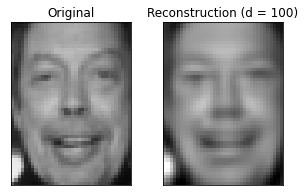

In [5]:
# Choose parameters
d = 100        # Dimensionality of PCA space
img_index = 0  # Row-index of original image in data

# Compute reconstruction
P = pca(M, d)
img_orig = data[img_index, :]
img_pca = M[img_index, :] @ P + np.mean(data, axis=0)

# Visualization
def plot_img(ax, img):
    """Plot a single image into ax"""
    ax.imshow(img.reshape(dim), cmap='gray', vmin=0, vmax=1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 3))

plot_img(ax1, img_orig)
ax1.set_title("Original")

plot_img(ax2, img_pca)
ax2.set_title(f"Reconstruction (d = {d})")

plt.show()

### Fair PCA

**Reconstruction Error:** 
First of all, we have to clearly define what we mean by a "fair" PCA algorithm - we need a mathematical criterion for "fairness". For this, we introduce the definition of the reconstruction error, which is a measure of the difference between the original images and their reconstruction. For two matrices $X$ and $Y$ of the same size, it is defined by
$$
\text{error}(X, Y) := \lVert X - Y \rVert_\text{F}^2 = \sum_i \sum_j \lvert X_{i,j} - Y_{i,j} \rvert^2.
$$
Note, that for the reconstruction error, it doesn't matter if $X$ and $Y$ are shifted by some average $T$, because the shifts cancel, i.e.
$
\lVert (X - T) - (Y - T) \rVert_\text{F}^2
= \lVert X - Y \rVert_\text{F}^2
$.

**Loss:** 
Since we want our algorithm to perform equally for women and men, let's consider two subgroups $A \in \mathbb{R}^{m_1 \times n}$ and $B \in \mathbb{R}^{m_2 \times n}$. Applying PCA separately to $A$ and $B$ yields the reconstructions $\hat{A}$ and $\hat{B}$. In terms of the reconstruction error, these two reconstructions are optimal. So, when using a *different* reconstruction $U \in \mathbb{R}^{(m_1 + m_2) \times n}$ ($U_A \in \mathbb{R}^{m_1 \times n}$ contains rows of $U$ that correspond to group $A$; $U_B \in \mathbb{R}^{m_2 \times n}$ contains rows of $U$ that correspond to group $B$), the reconstruction error on each group will increase. This is measured by the so-called reconstruction *loss*
$$
\begin{align*}
\text{loss}(A, U_A) &= \text{error}(A, U_A) - \text{error}(A, \hat{A}) \geq 0 \\
\text{loss}(B, U_B) &= \text{error}(B, U_B) - \text{error}(B, \hat{B}) \geq 0.
\end{align*}
$$
For some reconstruction $U$, the loss measures by how much the reconstruction error is increased with respect to the optimal reference reconstructions $\hat{A}$ and $\hat{B}$. 

**Fairness Criterion:**
The goal of Fair PCA (see Def. 4.4 in the above-mentioned paper) is to find a rank $d$ reconstruction $U$ that minimizes the larger of the two *average* group losses, i.e.
$$
\min_{U \in \mathbb{R}^{m \times n}, \,\text{rank}(U)\leq d} 
\max 
\Bigl\{
\frac{1}{\lvert A \rvert} \text{loss}(A, U_A), 
\frac{1}{\lvert B \rvert} \text{loss}(B, U_B)
\Bigr\}.
$$

The intuition behind this fairness criterion is that both groups, on average, "pay the same price" for the dimensionality reduction. The min-max optimization problem can be solved approximately by the so-called *Multiplicative Weight* algorithm. 



#### Part 1) Multiplicative Weight (MW)

**Core idea:** The core idea of this algorithm is to find "weights" for the groups $A$ and $B$ such that the average loss on both groups is the same (or at least similar). The pseudo-code given below is copied from the supplementary material of the original paper (see above).


<br />

Let us take a closer look at lines 1-7.
- **Step 1:** We start with equal initial weights $p^0$.
- **Step 2-6:**  The MW algorithm is an iterative approach. In each of the $T$ iterations, we try to improve/refine our choice of weights $p^t$.
- **Step 3:**  The oracle function (see below) applies PCA to the "weighted" dataset. It returns a projection matrix $P_t$ and the corresponding average group losses $m_1^t$ (group $A$) and $m_2^t$ (group $B$). MW will try to make these two numbers small and as close as possible. 
- **Step 4:**  Here, the weights are rescaled based on the corresponding loss value. Let's assume $m_1^t$ is large compared to $m_2^t$. So, $A$ seems to be "underrepresented" in the weighted dataset - in order to make the group losses match, we have to give group $A$ a larger weight. 
- **Step 5:**  After the rescaling, we renormalize such that the weights add up to $1$ again. 
- **Step 7:**  If we are "unlucky", the algorithm will tune the weights too aggressively, i.e. both weights (and the average group loss values) will jump back and forth between small and large values. Thus, in order to make the algorithm more robust, we average over all projection matrices in the last step. $\langle \,\cdot\,, \,\cdot\,\rangle$ denotes the Frobenius inner product $\langle X, Y \rangle = \sum_{i,j} X_{i,j} \cdot Y_{i,j}$. The arguments of the maximum correspond to the average loss values for the reconstructions using the projection matrix $P^*$, i.e. $\frac{1}{m_1}\text{loss}(A, A\cdot P^*)$ and $\frac{1}{m_2}\text{loss}(B, B\cdot P^*)$. 

**Task:** Implement the MW algorithm. 

In [6]:
def mw(alpha, beta, A, B, eta, T, d):
    """
    Multiplicative Weight algorithm.
    
    Parameters
    ----------
    alpha, beta : float
        Squared Frobenius norm of A_hat and B_hat respectively
    A : numpy.ndarray with shape=(m1, n)
        Data for group A
    B : numpy.ndarray with shape=(m2, n)
        Data for group B
    eta : float > 0
        Parameter for MW algorithm
    T : int > 0
        Number of iterations
    d : int > 0
        Rank of reconstruction matrix
    
    Returns
    -------
    P_star : numpy.ndarray with shape=(n, n)
        Fair projection matrix
    z_star : float
        Maximum of corresponding average group loss values 
    """
    n = A.shape[1]
    m1 = A.shape[0]
    m2 = B.shape[0]

    p_t = np.array([0.5, 0.5])
    P = np.zeros(shape=(n, n))
    
    for _ in range(1, T):

        P_t, m1_t, m2_t = oracle(p_t, alpha, beta, A, B, d)
        P += P_t
        p_t_hat = p_t * np.exp(eta*np.array([m1_t, m2_t]))
        p_t = p_t_hat/np.sum(p_t_hat)

    P_star = P/(T-1)
    U_A = np.linalg.norm(A @ P_star, ord='fro')**2
    U_B = np.linalg.norm(B @ P_star, ord='fro')**2
    z_star = np.max((alpha - (1/m1) * U_A, beta - (1/m2) * U_B))   
    return P_star, z_star

#### Part 2) Oracle

The next step will be to implement the oracle-function. Again, the pseudo-code given below is copied from the supplementary material of the original paper (see above).

<br />

- **Step 1:** We are given weights $p = (p_1, p_2)$. In the first step, we weight the group covariance matrices $\frac{1}{m_1} A^{\text{T}} A$ and $\frac{1}{m_2} B^{\text{T}} B$ by $p_1$ and $p_2$ respectively. This matrix corresponds to the covariance of the block matrix 
$$
\begin{pmatrix}
\sqrt{p_1 \frac{m}{m_1}} A\\
\sqrt{p_2 \frac{m}{m_2}} B
\end{pmatrix}
\quad \text{with} \quad m = m_1 + m_2
$$ 
So, you can basically think of this step as applying PCA to our LFW data $\begin{pmatrix}A\\B\end{pmatrix}$, where the groups are rescaled according to their relative sizes and weights. You can use `numpy.svd` for the computation of the left-singular vectors. 

- **Step 2:** Here, we compute the projection matrix $P^*$ and the corresponding loss values. 

**Task:** Implement the oracle algorithm. 

In [7]:
def oracle(p, alpha, beta, A, B, d):
    """
    Oracle function: Apply PCA to sum of "weighted" group covariance matrices
    
    Parameters
    ----------
    p : tuple with len(p)=2
        Relative weights p=(p_1, p_2) with p_1 + p_2 = 1
    alpha, beta : float
        Squared Frobenius norm of A_hat and B_hat respectively
    A : numpy.ndarray with shape=(m1, n)
        Data for group A
    B : numpy.ndarray with shape=(m2, n)
        Data for group B
    d : int > 0
        Rank of reconstruction matrix
    
    Returns
    -------
    P_star : numpy.ndarray with shape=(n, n)
        Projection matrix for sum of weighted group covariance matrices
    z1_star, z2_star : float
        Corresponding average group loss values 
    """
    m1 = A.shape[0]
    m2 = B.shape[0]
    m = m1 + m2
    
    A_weighted = np.sqrt(p[0] * m / m1) * A
    B_weighted = np.sqrt(p[1] * m / m2) * B

    V = np.vstack((A_weighted, B_weighted))
    C = np.cov(V, rowvar=False)
    # Apply SVD
    Q, _, _ = np.linalg.svd(C, hermitian=True)
    P_star = Q[:, 0:d] @ Q[:, 0:d].T

    z1 = alpha - (1/m1) * np.linalg.norm(A @ P_star, ord='fro')**2
    z2 = beta - (1/m2) * np.linalg.norm(B @ P_star, ord='fro')**2

    return P_star, z1, z2

#### Part 3) Fair PCA

Let's put it all together...

In [8]:
def fair_pca(A, B, eta, T, d): 
    """
    Fair PCA function: Apply Fair PCA algorithm
    
    Parameters
    ----------
    A : numpy.ndarray with shape=(m1, n)
        Data for group A
    B : numpy.ndarray with shape=(m2, n)
        Data for group B
    eta : float > 0
        Parameter for MW algorithm
    T : int > 0
        Number of iterations in MW algorithm
    d : int > 0
        Rank of reconstruction matrix
    
    Returns
    -------
    P_star : numpy.ndarray with shape=(n, n)
        Fair projection matrix
    """
    
    # Start fair PCA
    print(f"Fair PCA started (d = {d})")
    
    # Compute optimal reconstructions A_hat and B_hat
    P_A   = pca(A, d)
    A_hat = A @ P_A
    alpha = np.linalg.norm(A_hat, ord='fro')**2 / np.shape(A)[0]
    
    P_B   = pca(B, d)
    B_hat = B @ P_B
    beta  = np.linalg.norm(B_hat, ord='fro')**2 / np.shape(B)[0]
    
    # Call multiplicative weight algorithm and return projection matrix
    P_fair, z_fair = mw(alpha, beta, A, B, eta/d, T, d)
    print(f"Fair PCA finished. Final loss = {z_fair:.3f}")
    return P_fair

### PCA vs. Fair PCA

Now, let's see if our implementation of Fair PCA actually works and leads to a more balanced loss for both groups. For this, we are going to compare three different approaches:
1. Apply PCA to A and B *separately* and obtain the optimal reconstructions $\hat{A}$ and $\hat{B}$ (in this case, the loss will be zero).
2. Compute PCA of M and apply the projection matrix to both $A$ and $B$. This corresponds to the "classical" PCA approach and, as you have seen in the lecture, results in different losses for men and women.  
3. Apply the Fair PCA algorithm. 

**Task:** Compute the average reconstruction error for all approaches and the average loss values for approaches 2 and 3. Show two subplots: One for the reconstruction errors and one for the losses over $d \in \{ 1, ..., 10\}$. The result should look something like this.


In [15]:
def reconstruction_error(M, P):

    return np.linalg.norm(M @ P - M, ord='fro')**2 / np.shape(M)[0] 

def loss(M, P1, P2):

    return reconstruction_error(M, P2) - reconstruction_error(M, P1)

In [16]:
d_list = list(range(1,11))
eta = 20
T = 5

error_A_hat = []
error_B_hat = []
error_U_A = []
error_U_B = []
error_A_fair = []
error_B_fair = []

unfair_loss_A = []
unfair_loss_B = []
fair_loss_A = []
fair_loss_B = []

for d in d_list:
    P_A = pca(A, d)
    P_B = pca(B, d)
    error_A_hat.append(reconstruction_error(A, P_A))
    error_B_hat.append(reconstruction_error(B, P_B))

    P = pca(M, d)
    error_U_A.append(reconstruction_error(A, P))
    error_U_B.append(reconstruction_error(B, P))
    unfair_loss_A.append(loss(A, P_A, P))
    unfair_loss_B.append(loss(B, P_B, P))

    P_fair = fair_pca(A, B, eta, T, d)
    error_A_fair.append(reconstruction_error(A, P_fair))
    error_B_fair.append(reconstruction_error(B, P_fair))
    fair_loss_A.append(loss(A, P_A, P_fair))
    fair_loss_B.append(loss(B, P_B, P_fair))

Fair PCA started (d = 1)
Fair PCA finished. Final loss = 0.019
Fair PCA started (d = 2)
Fair PCA finished. Final loss = 0.058
Fair PCA started (d = 3)
Fair PCA finished. Final loss = 0.123
Fair PCA started (d = 4)
Fair PCA finished. Final loss = 0.110
Fair PCA started (d = 5)
Fair PCA finished. Final loss = 0.187
Fair PCA started (d = 6)
Fair PCA finished. Final loss = 0.217
Fair PCA started (d = 7)
Fair PCA finished. Final loss = 0.260
Fair PCA started (d = 8)
Fair PCA finished. Final loss = 0.236
Fair PCA started (d = 9)
Fair PCA finished. Final loss = 0.182
Fair PCA started (d = 10)
Fair PCA finished. Final loss = 0.207


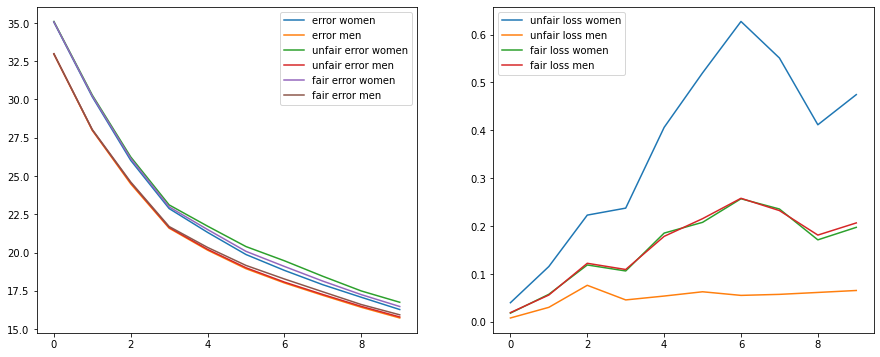

In [17]:
# Visualization
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].plot(error_A_hat, label='error women')
ax[0].plot(error_B_hat, label='error men')
ax[0].plot(error_U_A, label='unfair error women')
ax[0].plot(error_U_B, label='unfair error men')
ax[0].plot(error_A_fair, label='fair error women')
ax[0].plot(error_B_fair, label='fair error men')
ax[0].legend()

ax[1].plot(unfair_loss_A, label='unfair loss women')
ax[1].plot(unfair_loss_B, label='unfair loss men')
ax[1].plot(fair_loss_A, label='fair loss women')
ax[1].plot(fair_loss_B, label='fair loss men')
ax[1].legend();

It was really confusing that alpha and beta didn't correspond to the error definition (missing subtraction of the data?) and that on top of that the pseudocode step 7 also looked quite different from your description... It would be nice if you could clarify this better.